<a href="https://colab.research.google.com/github/anslemhuncho/Crowd-Epidemiology-/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 3747 images belonging to 10 classes.
Found 411 images belonging to 10 classes.
Found 2069 images belonging to 10 classes.
94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/50
118/118 [==============================] - ETA: 0s - loss: 2.5866 - accuracy: 0.1374

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 868s 7s/step - loss: 2.5866 - accuracy: 0.1374 - val_loss: 17.2172 - val_accuracy: 0.0706 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 74s 629ms/step - loss: 2.4399 - accuracy: 0.1641 - val_loss: 4.8504 - val_accuracy: 0.1363 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 73s 616ms/step - loss: 2.3375 - accuracy: 0.1879 - val_loss: 2.7493 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 73s 612ms/step - loss: 2.2750 - accuracy: 0.1908 - val_loss: 2.3381 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 71s 601ms/step - loss: 2.2449 - accuracy: 0.2060 - val_loss: 2.3845 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 68s 580ms/step - loss: 2.2438 - accuracy: 0.2020 - val_loss: 3.2099 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 7/50
118/118 [==============================] - 73s 623ms/

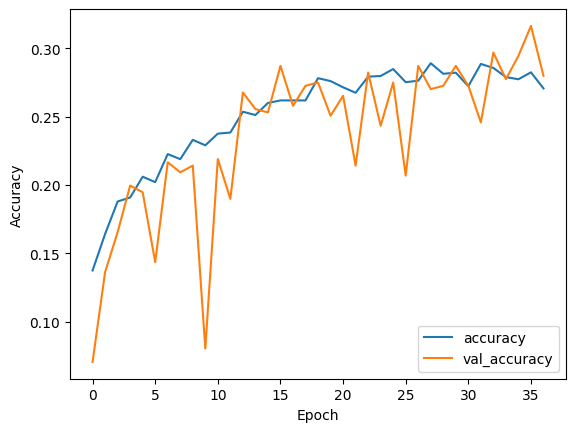

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths to your train and test folders
train_path = '/content/drive/MyDrive/Normalised data/train'
test_path = '/content/drive/MyDrive/Normalised data/test'

# Set up data generators with data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image dimensions
batch_size = 32
image_size = (224, 224)

# Generate batches of augmented data from train and test folders with validation split
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the ResNet model architecture
def build_resnet_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pretrained layers

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.5)(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the ResNet model
resnet_model = build_resnet_model()

# Define callbacks for model checkpoint, early stopping, and reducing learning rate
callbacks = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, save_format='h5'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
history = resnet_model.fit(
    train_generator,
    epochs=50,  # Increase number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

# Evaluate the model on the test data
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_generator)
print(f'Test Accuracy of ResNet Model: {test_accuracy_resnet}')

# Plot training history of the ResNet model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [3]:
# Print model summary
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

65/65 [==============================] - 11s 169ms/step


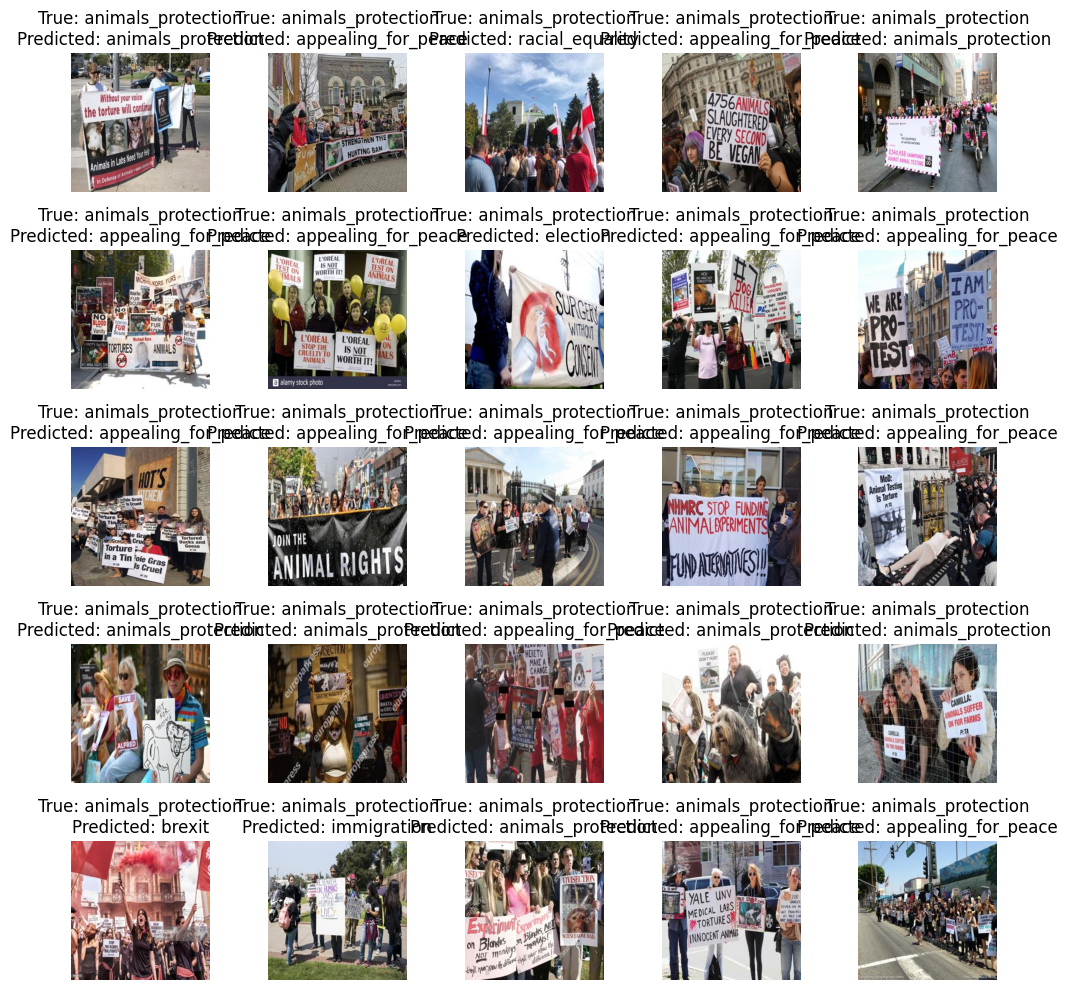

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true classes and filenames
y_true = test_generator.classes
filenames = test_generator.filenames

# Get class indices and names
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict classes for test data
y_pred = resnet_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot predictions
num_images = min(len(y_true), 25)  # Limit to 25 images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(plt.imread(f"{test_path}/{filenames[i]}"))
    plt.title(f"True: {class_names[y_true[i]]}\nPredicted: {class_names[y_pred_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


65/65 [==============================] - 10s 148ms/step


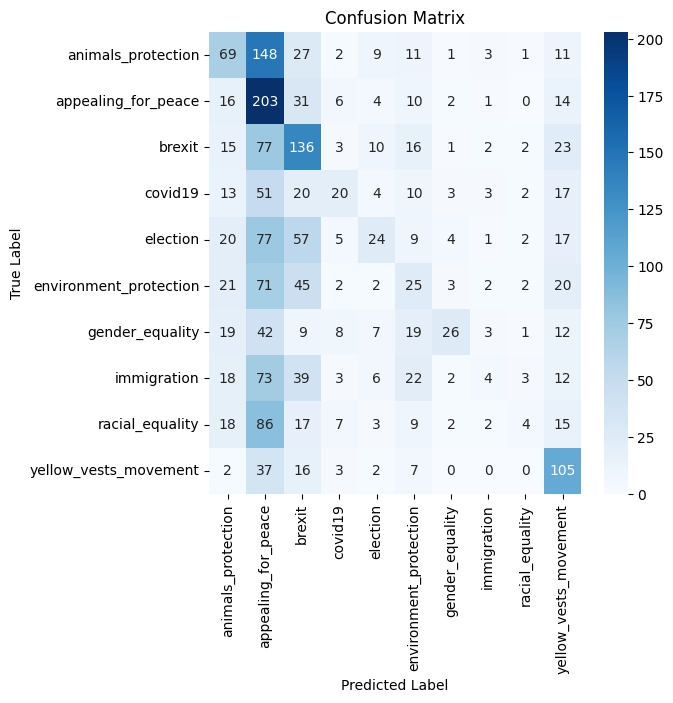


Classification Report:
                        precision    recall  f1-score   support

    animals_protection       0.33      0.24      0.28       282
   appealing_for_peace       0.23      0.71      0.35       287
                brexit       0.34      0.48      0.40       285
               covid19       0.34      0.14      0.20       143
              election       0.34      0.11      0.17       216
environment_protection       0.18      0.13      0.15       193
       gender_equality       0.59      0.18      0.27       146
           immigration       0.19      0.02      0.04       182
       racial_equality       0.24      0.02      0.04       163
 yellow_vests_movement       0.43      0.61      0.50       172

              accuracy                           0.30      2069
             macro avg       0.32      0.26      0.24      2069
          weighted avg       0.31      0.30      0.26      2069



In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for test data
y_pred = resnet_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
y_true = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Print classification report
print("\nClassification Report:")
print(report)
